
<b><h1 style="text-align: center;color:aqua">Aero-Engine Blade <span style="color:yellow">Defect 
Detection</span></h1><b>
<h4 style="text-align: center;color:yellow">John Alber, <span style="color:aqua">8976716</span></h4>
<h4 style="text-align: center;color:yellow">Simardeep Singh, <span style="color:aqua">8976948</span></h4>


#### **This project focuses on the identification and classification of defects in aero-engine blades. We employ a convolutional neural network (CNN), more specifically, a deformable convolutional neural network (Deformable ConvNet) capable of adapting to geometric transformations, to detect various types of defects like scratches, dots, creases, and damage. The robustness of this approach allows for effective performance despite the complex patterns and variations in the blade images.**

[`LINK TO KAGGLE DATASET`](https://www.kaggle.com/datasets/wolfmedal/aero-engine-defect-new?resource=download)

#### `Data Files Path`

The [dataset]('https://www.kaggle.com/discussions/accomplishments/479710') comprises numerous high-resolution images of turbine blades, spanning diverse engine types and various defect conditions. These images are stored digitally, boasting moderate resolution and exceptional clarity to facilitate the clear identification and detailed analysis of defects. Credits to HSLING for this dataset from kaggle.

In [1]:
train_images_dir = 'data\\Aero-engine_defect-detect_new\\images\\train' #Path
train_labels_dir = 'data\\Aero-engine_defect-detect_new\\images\\val'
val_images_dir = 'data\\Aero-engine_defect-detect_new\labels\\train'
val_labels_dir = 'data\\Aero-engine_defect-detect_new\\labels\\val'

Path of the data is set in variable

####   `Import Liabraries`

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torch.utils.data.dataloader import default_collate
from torchvision.transforms import Compose, Resize, ToTensor
from glob import glob
from PIL import Image,ImageTk
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
import numpy as np

Imported all the required Libraries

####    `Data Preprocessing`
#### **The TurbineBladeDataset class handles data loading and preprocessing**

In [4]:

class TurbineBladeDataset(Dataset):
    def __init__(self, image_dir, label_dir=None, class_map=None, transform=None):
        self.image_files = glob(os.path.join(image_dir, '*.jpg'))
        self.label_dir = label_dir
        self.class_map = class_map  
        self.transform = transform if transform else Compose([
            Resize((224, 224)), 
            ToTensor()
        ])
        print(f"Found {len(self.image_files)} images in {image_dir}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        label = -1  
        bbox = [0.0, 0.0, 0.0, 0.0]  
        
        if self.label_dir:
            label_file = os.path.join(self.label_dir, os.path.splitext(os.path.basename(img_path))[0] + '.txt')
            if os.path.exists(label_file):
                try:
                    with open(label_file, 'r') as file:
                        line = file.readline().strip()
                        label, bbox = self.parse_label(line)
                except Exception as e:
                    print(f"Error reading {label_file}: {e}")
        
        
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(bbox, dtype=torch.float32)

    @staticmethod
    def parse_label(label_str):
        parts = label_str.split()
        class_id = int(parts[0])
        bbox = [float(x) for x in parts[1:]]
        return class_id, bbox


In [5]:

def custom_collate(batch):
    batch = [item for item in batch if item[1] != -1]
    if not batch:
        return torch.Tensor(), torch.Tensor(), torch.Tensor()
    return default_collate(batch)


#### `Model Definition`
#### **DeformableConvNet**

This model is a convolutional neural network (CNN) called "DeformableConvNet". It is  designed for image classification. It consists of two convolutional layers followed by max pooling, then two fully connected layers for classification. The model takes an input image and outputs the logits for each class.

In [6]:

class DeformableConvNet(nn.Module):
    def __init__(self, num_classes=4):
        super(DeformableConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



#### `Training Procedure`
The training process involves running multiple epochs where the model learns to minimize the error between its predictions and the true labels.

In [19]:
train_dataset = TurbineBladeDataset(train_images_dir, train_labels_dir)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate)

model = DeformableConvNet(num_classes=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, num_epochs=15):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels, _ in train_loader:
            if images.size(0) == 0:
                continue
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch + 1}: Loss {total_loss / len(train_loader)}')

train_model(model, train_loader, criterion, optimizer)


Found 257 images in C:\Foundations_of_Machine_Learning_Frameworks_lab\Project\Aero-engine_defect-detect_new\images\train
Epoch 1: Loss 2.4641415511860565
Epoch 2: Loss 0.8993928379872266
Epoch 3: Loss 0.8378185805152444
Epoch 4: Loss 0.7273167827550102
Epoch 5: Loss 0.6709664499058443
Epoch 6: Loss 0.7701271281522863
Epoch 7: Loss 0.6570083376239327
Epoch 8: Loss 0.5181851422085482
Epoch 9: Loss 0.4549737112487064
Epoch 10: Loss 0.40508269737748537
Epoch 11: Loss 0.4670435029684621
Epoch 12: Loss 0.5224999943200279
Epoch 13: Loss 0.3593538269838866
Epoch 14: Loss 0.30164120609269424
Epoch 15: Loss 0.3199978321790695


This indicates that the training progress of a neural network model over 15 epochs using a dataset containing 257 images. Initially, the loss is relatively high at 2.46 in the first epoch but steadily decreases over subsequent epochs, reaching a low value of 0.32 by epoch 15. Eventhough there are some fluctuations in the loss values, overall, they demonstrate a decreasing trend, suggesting that the model is effectively learning and converging towards a better solution. This reduction in loss indicates improved performance of the model on the training data, highlighting successful training and learning progress.

#### `Evaluation Metrics`
After training, we evaluate the model's performance on unseen data from the validation set to ensure its effectiveness and generalization capability.

The function `evaluate_model` iterates through the validation DataLoader, computes the model's predictions on each batch of images, compares them with the ground truth labels, and calculates the accuracy.

In [21]:
def evaluate_model(model, val_loader):
    model.eval()
    total_correct = 0
    total_images = 0
    with torch.no_grad():
        for images, labels, _ in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_images += labels.size(0)
    accuracy = total_correct / total_images * 100
    print(f'Validation Accuracy: {accuracy:.2f}%')

# Prepare the validation dataset and loader
val_dataset = TurbineBladeDataset(val_images_dir, val_labels_dir)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate)

# Evaluate the model
evaluate_model(model, val_loader)


Found 73 images in C:\Foundations_of_Machine_Learning_Frameworks_lab\Project\Aero-engine_defect-detect_new\images\val
Validation Accuracy: 92.31%


The output indicates that there are 73 images in the validation dataset, and the model achieved an accuracy of 92.31% on this dataset. This suggests that the model performs well on unseen data, with a high accuracy rate, indicating its effectiveness in generalizing from the training data to new, unseen examples.

#### `Results Visualization`
To better interpret the model's performance, we generate a confusion matrix and a classification report. 

#### **Confusion Matrix and Classification Report**

              precision    recall  f1-score   support

     scratch       0.91      0.97      0.94        33
       dirty       1.00      1.00      1.00         1
      damage       0.94      0.83      0.88        18

    accuracy                           0.92        52
   macro avg       0.95      0.93      0.94        52
weighted avg       0.92      0.92      0.92        52



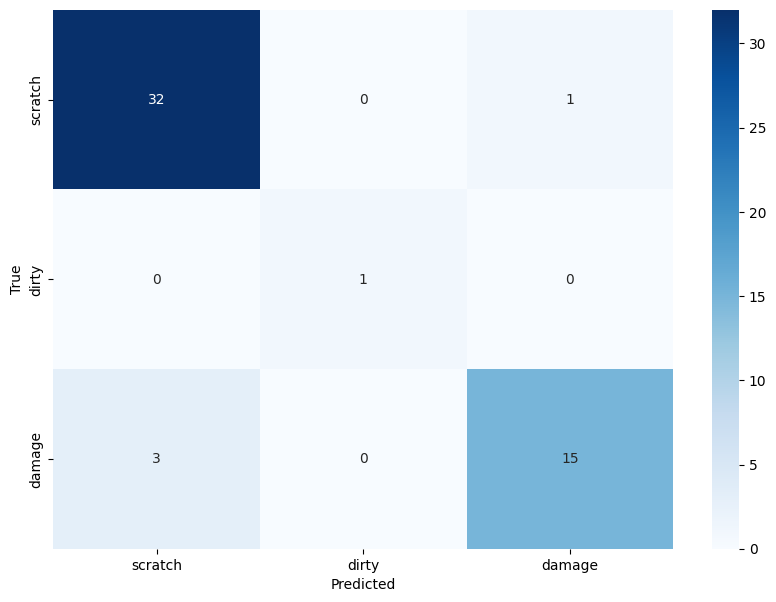

In [22]:

def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def get_predictions_and_labels(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels, _ in data_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Get labels and predictions
labels, preds = get_predictions_and_labels(model, val_loader)

# Plot confusion matrix and classification report
class_names = ['scratch',  'dirty', 'damage']  
print(classification_report(labels, preds, target_names=class_names))
plot_confusion_matrix(labels, preds, class_names)


The classification report provides the overall accuracy, macro average, and weighted average values. The model demonstrates high precision, recall, and F1-score for most classes, with an overall accuracy of 92%. It includes precision, recall, and F1-score for each class ("scratch," "dirty," and "damage").

The rows of the confusion matrix represent the actual categories of the images, and the columns represent the categories that the algorithm predicted the images belonged to. The diagonal cells of the confusion matrix show the number of images that were correctly classified. The off-diagonal cells show the number of images that were classified incorrectly. The algorithm performed well at classifying scratched images and images with damage. 

#### `GUI Implementation`

In [ ]:

class ImageClassifierGUI:
    def __init__(self, model):
        self.model = model
        self.root = tk.Tk()
        self.root.title("Image Classifier")

        self.label = tk.Label(self.root, text="Upload an image:")
        self.label.pack()

        self.upload_button = tk.Button(self.root, text="Upload Image", command=self.upload_image)
        self.upload_button.pack()

        self.image_label = tk.Label(self.root)
        self.image_label.pack()

        self.prediction_label = tk.Label(self.root, text="")
        self.prediction_label.pack()

    def upload_image(self):
        file_path = filedialog.askopenfilename()
        if file_path:
            image = Image.open(file_path)
            image = image.resize((224, 224))  # Resize image to match model input size
            image = ToTensor()(image).unsqueeze(0)  # Convert image to tensor and add batch dimension
            prediction = self.predict(image)
            self.display_image(image)
            self.prediction_label.config(text=f"Prediction: {prediction}")

    def predict(self, image):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(image)
            _, predicted = torch.max(outputs, 1)
            prediction = self.get_class_name(predicted.item())
        return prediction

    def get_class_name(self, class_index):
        class_names = ['scratch', 'dirty', 'damage']  
        return class_names[class_index]

    def display_image(self, image):
        image = image.squeeze(0)  
        image = image.permute(1, 2, 0)  
        image = (image * 255).numpy().astype(np.uint8)  
        image = Image.fromarray(image)
        image = ImageTk.PhotoImage(image)
        self.image_label.configure(image=image)
        self.image_label.image = image

    def run(self):
        self.root.mainloop()


classifier = ImageClassifierGUI(model)
classifier.run()
